### Importing libraries and setting up google drive

In [15]:
import os
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import random
import tensorflow as tf
import re
import datetime
import io
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from __future__ import print_function

from keras.models import Model, load_model
from keras.layers import Input, LSTM, GRU, CuDNNGRU, Dense, TimeDistributed, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization, Activation, Concatenate, Bidirectional, concatenate,ZeroPadding2D
from keras.callbacks import EarlyStopping
import keras.backend as K
import numpy as np
from keras.optimizers import Adam
#from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Reading the filename from the words.txt file and creating a file path for each image

In [0]:
data_folder = "/content/gdrive/My Drive/Colab Notebooks/words/"
maxTextLen = 30

dataset = []

f=open('/content/gdrive/My Drive/Colab Notebooks/words.txt')
chars = set()
for line in f:
    # ignore comment line
    if not line or line[0]=='#':
        continue

    lineSplit = line.strip().split(' ')
    assert len(lineSplit) >= 9

    # filename: part1-part2-part3 --> part1/part1-part2/part1-part2-part3.png
    fileNameSplit = lineSplit[0].split('-')
    fileName = data_folder + fileNameSplit[0] + '/' + fileNameSplit[0] + '-' + fileNameSplit[1] + '/' + lineSplit[0] + '.png'

    # GT text are columns starting at 9
    gtText = ' '.join(lineSplit[8:])[:maxTextLen]
    chars = chars.union(set(list(gtText)))

    # put sample into list
    dataset.append((gtText, fileName))

### Reducing the dataset size

In [3]:
print('length of original dataset',len(dataset))
max_len = int(len(dataset) * 0.05)
dataset = dataset[:max_len]
print('length of reduced dataset',len(dataset))

# checking an example
dataset[60]

length of original dataset 115320
length of reduced dataset 5766


('any',
 '/content/gdrive/My Drive/Colab Notebooks/words/a01/a01-000x/a01-000x-01-00.png')

### Resizing the image and creating a list with unique characters.

In [4]:
imgs = []
words = []
target_characters = set()


size = 52
x_size = size
y_size = size *2

for ind in range(len(dataset)):
    fpath = dataset[ind][1]
    img = cv2.imread(fpath, 0)
    if img is not None:
      resized_image = cv2.resize(img, (y_size, x_size))
      (m, s) = cv2.meanStdDev(resized_image)
      m = m[0][0]
      s = s[0][0]
      resized_image = resized_image - m
      resized_image = resized_image / s if s > 0 else resized_image
      imgs.append(resized_image)
      words.append(dataset[ind][0])
      word_char = list(dataset[ind][0])
      for char in word_char:
        target_characters.add(char)
        
array_images = np.asarray(imgs)

# adding extra tokens
target_characters.add('[')
target_characters.add(']')

target_characters

{' ',
 '"',
 '#',
 "'",
 '(',
 ')',
 '*',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'Z',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [5]:
array_images.shape

(5765, 52, 104)

### Plotting a random image.

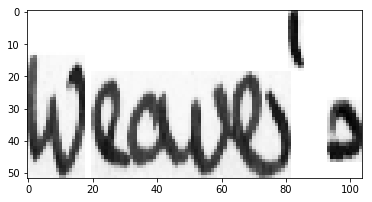

word =  Weaver's


In [6]:
index = random.randint(0, array_images.shape[0] - 1)
pyplot.imshow(array_images[index, :, :], cmap=pyplot.get_cmap('gray'))
pyplot.show()
print("word = ", words[index])

### Split train and test set

In [0]:
random_state = 46
test_size=0.2
array_images_train_val, array_images_test, words_train_val, words_test = train_test_split(array_images, words, random_state=random_state, test_size=test_size)  

### Reshape to feed into tensorflow

In [0]:
array_images_train_val = np.reshape(array_images_train_val, (-1, x_size, y_size, 1))
array_images_test = np.reshape(array_images_test, (-1, x_size, y_size, 1))

In [9]:
array_images_test.shape

(1153, 52, 104, 1)

### Data augmentation

In [0]:
# define data preparation
train_datagen = ImageDataGenerator(
                             #featurewise_center=True, featurewise_std_normalization=True, 
                             #samplewise_center=True, samplewise_std_normalization=True,
#                             rescale=1./255,
                             #rotation_range=5, width_shift_range=0.05, height_shift_range=0.1, 
                             #shear_range = 3, zoom_range = [0.9, 1.1], 
                             rotation_range=5, width_shift_range=0.1, height_shift_range=0.2, 
                             shear_range = 5, zoom_range = [0.8, 1.2], 
                             horizontal_flip=False, data_format='channels_last')

val_datagen = ImageDataGenerator(
                                 #rescale=1./255, 
                                 #samplewise_center=True, samplewise_std_normalization=True,
                                 data_format='channels_last')

### One-hot Vectorization.

In [11]:
# Vectorize the data.

target_texts = []

for word in words_train_val:
    target_text = '[' + word + ']'
    target_texts.append(target_text)
    
num_encoder_tokens = y_size
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = x_size   #size after the convolution
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(words_train_val))
print('Number of input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

decoder_input_data = np.zeros( (len(words_train_val), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

decoder_target_data = np.zeros( (len(words_train_val), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for i, target_text in enumerate(target_texts):
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

Number of samples: 4612
Number of input tokens: 104
Number of unique output tokens: 75
Max sequence length for inputs: 52
Max sequence length for outputs: 20


### Splitting the train data into a set of another training and validation sets, Input data: array_images_train, decoder_input_data_train, decoder_target_data_train

In [0]:
random_state = 4
val_size = 0.1
array_images_train, array_images_val, decoder_input_data_train, decoder_input_data_val, decoder_target_data_train, decoder_target_data_val, words_train, words_val= train_test_split(array_images_train_val, decoder_input_data, decoder_target_data, words_train_val, random_state=random_state, test_size=val_size)  

### Optimizer

In [0]:
latent_dim = 512  # Latent dimensionality of the encoding space.

#optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

### Model Architecture

In [16]:
encoder_inputs = Input(shape=(x_size, y_size, 1), name='input_encoder')
encoder_layer = ZeroPadding2D((3,3))(encoder_inputs)

encoder_layer = Conv2D(16, (7, 7), padding='same', use_bias=False,strides=1, name='conv_1')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_1')(encoder_layer)
encoder_layer = Activation('relu', name='activation_1')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_1')(encoder_layer)

encoder_layer = Conv2D(32, (5, 5), padding='same', use_bias=False,strides=1, name='conv_2')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_2')(encoder_layer)
encoder_layer = Activation('relu', name='activation_2')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(2, 2), padding='valid', name='maxpool_2')(encoder_layer)

encoder_layer = Conv2D(64, (5, 5), padding='same', use_bias=False,strides=1, name='conv_3')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_3')(encoder_layer)
encoder_layer = Activation('relu', name='activation_3')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(1, 2), padding='valid', name='maxpool_3')(encoder_layer)

encoder_layer = Conv2D(128, (3, 3), padding='same', use_bias=False,strides=1, name='conv_4')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_4')(encoder_layer)
encoder_layer = Activation('relu', name='activation_4')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(1, 2), padding='valid', name='maxpool_4')(encoder_layer)

encoder_layer = Conv2D(256, (3, 3), padding='same', use_bias=False,strides=1, name='conv_5')(encoder_layer)
encoder_layer = BatchNormalization(name='batch_norm_5')(encoder_layer)
encoder_layer = Activation('relu', name='activation_5')(encoder_layer)
encoder_layer = MaxPooling2D(pool_size=(1, 2), padding='valid', name='maxpool_5')(encoder_layer)

#encoder_layer = Conv2D(512, (3, 3), padding='same', use_bias=False,strides=1, name='conv_6')(encoder_layer)
#encoder_layer = BatchNormalization(name='batch_norm_6')(encoder_layer)
#encoder_layer = Activation('relu', name='activation_6')(encoder_layer)
#encoder_layer = MaxPooling2D(pool_size=(1, 2), padding='valid', name='maxpool_6')(encoder_layer)

encoder_layer = Reshape((-1, 256), name='reshape')(encoder_layer)

#encoder = GRU(latent_dim, return_state=True)

if not tf.test.is_gpu_available():
    encoder = Bidirectional(CuDDNGRU(latent_dim, return_state=True))
else:
    encoder = Bidirectional(GRU(latent_dim, return_state=True))

encoder_outputs, forward_h, backward_h= encoder(encoder_layer)

state_h = Concatenate()([forward_h, backward_h])

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='input_decoder')

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
if tf.test.is_gpu_available():
    decoder_gru  = CuDNNGRU(latent_dim*2, return_sequences=True, return_state=True, name='gru_decoder')
else:
    decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)

#decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True, name='gru_decoder')

decoder_outputs,_ = decoder_gru(decoder_inputs, initial_state=[state_h])

#decoder_outputs = dropout(decoder_outputs)

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='dense')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      (None, 52, 104, 1)   0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 58, 110, 1)   0           input_encoder[0][0]              
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 58, 110, 16)  784         zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
batch_norm_1 (BatchNormalizatio (None, 58, 110, 16)  64          conv_1[0][0]                     
____________________________________________________________________________________________

### Model Training

In [18]:
train = True

batch_size = 64  # Batch size for training.
batch_size_val = 1
epochs = 25 # Number of epochs to train for.

n_times_aug = 1

# Early stopping  
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1, mode='auto')

if train == True:    
    # Run training
    model.compile(optimizer=optimizer, loss='categorical_crossentropy')

    model.fit([array_images_train, decoder_input_data_train], decoder_target_data_train, batch_size=batch_size,
              epochs=epochs, validation_data = ([array_images_val, decoder_input_data_val], decoder_target_data_val) )
    
#    model.fit_generator(train_datagen.flow([array_images_train, decoder_input_data_train], decoder_target_data_train, batch_size=batch_size),
#                        steps_per_epoch = n_times_aug * len(array_images_train) / batch_size, epochs=epochs, 
#                        validation_data = val_datagen.flow([array_images_val, decoder_input_data_val], decoder_target_data_val, batch_size=len(array_images_val)),
# #                       validation_data = (array_images_val, targhe_one_hot_val), 
#                        validation_steps =  1, verbose=1
#                        ,callbacks=[early_stop])

    model.save('/content/gdrive/My Drive/Colab Notebooks/model_bigru.h5')

Train on 4150 samples, validate on 462 samples
Epoch 1/25
4150/4150 [==============================] - 20s 5ms/step - loss: 0.2931 - val_loss: 0.3943
Epoch 2/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.1116 - val_loss: 0.3359
Epoch 3/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.0435 - val_loss: 0.2395
Epoch 4/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.0151 - val_loss: 0.2286
Epoch 5/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.0076 - val_loss: 0.2339
Epoch 6/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.0042 - val_loss: 0.2267
Epoch 7/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.0024 - val_loss: 0.2301
Epoch 8/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.0012 - val_loss: 0.2317
Epoch 9/25
4150/4150 [==============================] - 17s 4ms/step - loss: 0.0015 - val_loss: 0.2393
Epoch 10/25
4150/4150 [===

In [0]:
# loading the model
train=False
if train == False:
    from keras.models import load_model    
    model = load_model('/content/gdrive/My Drive/Colab Notebooks/model.h5')

### Inference models

In [0]:
encoder_inference = Model(encoder_inputs, state_h)

decoder_state_input_h = Input(shape=(latent_dim*2,))
#decoder_state_input_c = Input(shape=(latent_dim*2,))

decoder_states_inputs=[decoder_state_input_h]

decoder_outputs, state_h= decoder_gru(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h]

decoder_outputs = decoder_dense(decoder_outputs)

decoder_inference = Model([decoder_inputs]+decoder_states_inputs,[decoder_outputs] + decoder_states)

#decoder_inference = Model( [decoder_inputs] + decoder_states_inputs, [decoder_outputs])

# Reverse-lookup token index to decode sequences
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_inference.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['[']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_inference.predict([target_seq,states_value])

        #output_tokens = decoder_inference.predict( [target_seq] + states_value )
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == ']' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = h

    return decoded_sentence

### Prediction on test data

In [22]:
pred_test = []

for ind in range(len(words_test)):    
#for ind in range(0, 100):  
    row_word = []

    input_seq = np.reshape(array_images_test[ind,:,:], (-1, x_size,  y_size, 1) )
    
    #input_seq = array_images_test[ind,:]
    
    decoded_word = decode_sequence(input_seq)
    decoded_word = decoded_word.replace("]", "")
    
    #add fake characters if len <7
    #if len(decoded_sentence) < 7:
    #    decoded_sentence += '-' * (7 - len(decoded_sentence))
    #elif len(decoded_sentence) > 7:
    #    decoded_sentence = decoded_sentence[0:7]
    
    
    row_word.append(words_test[ind])
    row_word.append(decoded_word)
    
    pred_test.append(row_word)
    
    print('True word:', words_test[ind])
    print('Decoded word:', decoded_word, '\n')

True word: Roderick
Decoded word: Rhodesia 

True word: his
Decoded word: his 

True word: is
Decoded word: is 

True word: gather
Decoded word: yial 

True word: tough
Decoded word: tough 

True word: .
Decoded word: . 

True word: ,
Decoded word: , 

True word: Senator
Decoded word: duscenter 

True word: parties
Decoded word: problem 

True word: payments
Decoded word: peegened 

True word: Minister
Decoded word: Minister 

True word: to
Decoded word: of 

True word: Kenneth
Decoded word: Keanchester 

True word: plans
Decoded word: plans 

True word: Mr.
Decoded word: Mr. 

True word: the
Decoded word: the 

True word: and
Decoded word: and 

True word: Roy
Decoded word: Roy 

True word: would
Decoded word: would 

True word: ,
Decoded word: , 

True word: command
Decoded word: Commoniealth 

True word: by
Decoded word: by 

True word: last
Decoded word: last 

True word: and
Decoded word: and 

True word: placing
Decoded word: getuing 

True word: Virginia
Decoded word: Mirginia 


### Accuracy score in terms of character and word level.

In [0]:
def score_prediction(pred_list):
    """
    returns accuracy of "true word" correctly identified, 
    as well as the mean accuracy of characters identified
    """
    n_word_identified = 0
    n_characters_identified = 0
    
    list_accuracy_characters = []
    
    for i in range(len(pred_list)):
        pred_row = pred_list[i] 
        
        #if len(pred_row[0]) != len(pred_row[1]):
        #    raise Exception
        
        #check if true word are the same
        if pred_row[0] == pred_row[1]:
            n_word_identified += 1
            
        #check the number of characters that are the same
        for k in range(len(pred_row[0])):
            if pred_row[0][k] in pred_row[1]:
                n_characters_identified += 1
                
        #accuracy_characters = n_characters_identified / float(len(pred_row[0]))
        #list_accuracy_characters.append(accuracy_characters)  

    accuracy = n_word_identified/len(pred_list) 

    array_accuracy_characters = np.asarray(list_accuracy_characters)
    #accuracy_char = np.mean(array_accuracy_characters)
    accuracy_char = float(n_characters_identified / (len(pred_list) * 7.))
    #accuracy, accuracy_char = score_prediction(pred_test)
    return accuracy, accuracy_char

In [0]:
accuracy, accuracy_char = score_prediction(pred_test)

In [25]:
print('true word recognition: ', round(accuracy * 100, 3), '%')
print('characters recognition: ', round(accuracy_char * 100, 3), '%')

true word recognition:  55.16 %
characters recognition:  47.441 %
